In [1]:
"""
make heatmaps for outputs of 6_allbyallABA.py
modified from spatial/4_heatmapST.ipynb

Shaina Lu
Zador & Gillis Labs
April 2020
"""

'\nmake heatmaps for outputs of 6_allbyallABA.py\nmodified from spatial/4_heatmapST.ipynb\n\nShaina Lu\nZador & Gillis Labs\nApril 2020\n'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

In [3]:
#function for matplotlib formatting
def set_style():
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in Data

In [4]:
#infiles
ABA_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"

In [5]:
ontology = pd.read_csv(ONTOLOGY_PATH)
ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
ontology = ontology.fillna(-1)  #make root's parent -1

In [6]:
ABApropont = pd.read_hdf(ABA_FILT_PATH, key='propontology', mode='r')

# Heatmap Plotting Functions

__upper triangular heat map__

In [7]:
def uppertriheatmap(allbyall):
    """get a first look at allbyall outfiles by visualizing as heat map"""
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set()
    mask = np.zeros_like(allbyall)   #zero matrix of size allbyall
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(allbyall, mask=mask, square=True, vmax=1, vmin=0)
        
    plt.show()

__cluster map code__

In [21]:
def clustermap(allbyall, ontology, filename):
    """create clustermap for given all by all"""
    #copy uppertriangular to lower triangular
    allbyall2 = allbyall
    allbyall2 = allbyall.fillna(0, inplace=False)
    temp = allbyall2.T
    allbyall2 = allbyall2.values  #convert to numpy
    temp = temp.values
    allbyall2[np.tril_indices_from(allbyall)] = temp[np.tril_indices_from(allbyall)]
    #are there any missing values in duplicated matrix?
    print("are there any missing values after copying over diagonal?")
    print(np.isnan(allbyall2).any())
    
    #color bar code to get rows indicated by region in cluster map
    #areas: CTX (incl hippo), CNU (striatum and pallidum),
    #IB (thalamus + hypothalamus), MB, HB, and CB (Cerebellum)
    #first get id's and allen color for these areas
    acros = ["CTX", "CNU", "IB", "MB", "HB", "CB", "root"]
    areaids = []
    allencolor = []
    for area in acros:
        areaids.append(ontology.loc[ontology.acronym == area, "id"].values[0])
        allencolor.append(ontology.loc[ontology.acronym == area, "allencolor"].values[0])
        
    #propogate brain areas up to sup structure for index
    supstrucs = []
    for area in list(allbyall):
        while int(area) not in areaids:
            area = int(ontology.loc[ontology.id==int(area),"parent"])
        supstrucs.append(int(area))
        
    #create color map for cluster map
    cbarmap = dict(zip(areaids,allencolor))
    row_colors = pd.Series(supstrucs).map(cbarmap)
    row_colors.name = " " #no name so it can be centered below
    row_colors.index = list(allbyall)

    #use a dataframeinstead for the colorbar 
    #to get wider colorbar by tricking multi-level labels
    row_colors_df = pd.DataFrame(row_colors)
    for i in range(20):
        #if i == 5:
        #    row_colors_df["main brain areas"] = row_colors
        #    continue
        row_colors_df[" "*i] = row_colors
    
    #clustering using inverse of AUROC as distance
    #I think this is the correct one
    allbyall2_df = pd.DataFrame(allbyall2)
    allbyall2_df.set_index(pd.Index(list(allbyall)), inplace=True)
    allbyall2_df.index.name = "all brain areas"
    allbyall2_df.columns = list(allbyall)
    allbyall2_df.columns.name = "all brain areas"

    #use re-centered AUROC as similarity metric
    distm = np.abs(allbyall2_df - 0.5)        #center the aurocs at 0.5, get abs value
    np.fill_diagonal(distm.values, 0)         #force diagonal to be 0, required for linkage
    linkage = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(distm), method='average')

    #plot parameters
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set(font_scale=1.25)

    #control color of main diagonal
    diagmask = np.zeros(allbyall2.shape)
    diagmask[np.diag_indices_from(allbyall2)] = True
    
    g = clustmap = sns.clustermap(allbyall2_df, row_linkage=linkage, col_linkage=linkage,\
                                  square=True, xticklabels=False, yticklabels=False, vmax=1,\
                                  mask = diagmask, \
                                  row_colors=row_colors_df, cbar_kws={'label': 'AUROC'})
    #legend hack
    legend_dict = dict(zip(acros, allencolor))
    for label in legend_dict.keys():
        g.ax_col_dendrogram.bar(0, 0, color=legend_dict[label],
                                label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc=[0,1], ncol=3, title="main brain areas")
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

__upper triangular histogram code__

In [9]:
def uppertrihist(allbyall, xaxislab, ylimflag, ylim1, ylim2, filename):
    """histogram of upper triangular of heatmaps"""
    allbyall = allbyall.values #convert to numpy
    histdata = allbyall[np.triu_indices_from(allbyall,k=1)]
    print("number of 0's in upper triangular: %d" %(len(np.where(histdata == 0)[0])))
    histdata = histdata[histdata != 0] #remove 0's
    
    #plot
    set_style()
    plt.hist(histdata, bins=100)
    plt.xlabel(xaxislab)
    plt.ylabel("counts")
    plt.axvline(x=np.mean(histdata), c="black", linestyle='--')
    plt.xlim([0,1.02])
    if ylimflag == 1:
        plt.ylim([ylim1,ylim2])
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    #mean AUROC for upper triangular
    print("mean AUROC for upper triangular: %f" %(np.mean(histdata)))

__scatter plot of folds code__

In [10]:
def scatfolds(fold1, fold2, filename):
    """scatter plot of upper triangular of the two folds"""
    fold1 = fold1.values
    fold2 = fold2.values
    fold1 = fold1[np.triu_indices_from(fold1, k=1)]
    fold2 = fold2[np.triu_indices_from(fold2, k=1)]
    #fold1 = fold1[fold1 != 0] #remove 0's
    #fold2 = fold2[fold2 != 0]
    
    #plot
    set_style()
    plt.scatter(fold1, fold2)
    plt.xlabel("fold 1 AUROCs")
    plt.ylabel("fold 2 AUROCs")
    plt.xlim([0,1.1])
    plt.ylim([0,1.1])
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [11]:
def scatfolds2(fold1, fold2, filename):
    """scatter plot of upper triangular of the two folds"""
    fold1 = fold1.values
    fold2 = fold2.values
    fold1 = fold1[np.triu_indices_from(fold1, k=1)]
    fold2 = fold2[np.triu_indices_from(fold2, k=1)]
    #fold1 = fold1[fold1 != 0] #remove 0's
    #fold2 = fold2[fold2 != 0]
    
    #plot
    set_style()
    sns.jointplot(fold1, fold2,kind='hex').set_axis_labels("fold 1 AUROCs","fold 2 AUROCs")
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

# ABA ISH LASSO all by all alpha = 0.1

### fold 1

__read in all by all files__

In [4]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1_train0420.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1_test0420.csv"

In [5]:
train_allbyall = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall = train_allbyall.set_index(train_allbyall.columns)

test_allbyall = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall = test_allbyall.set_index(test_allbyall.columns)

In [6]:
train_allbyall.shape

(560, 560)

__plots__

train set


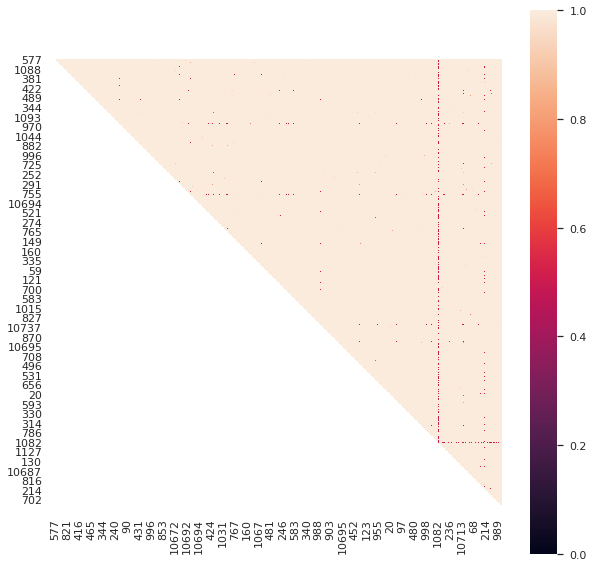

test set


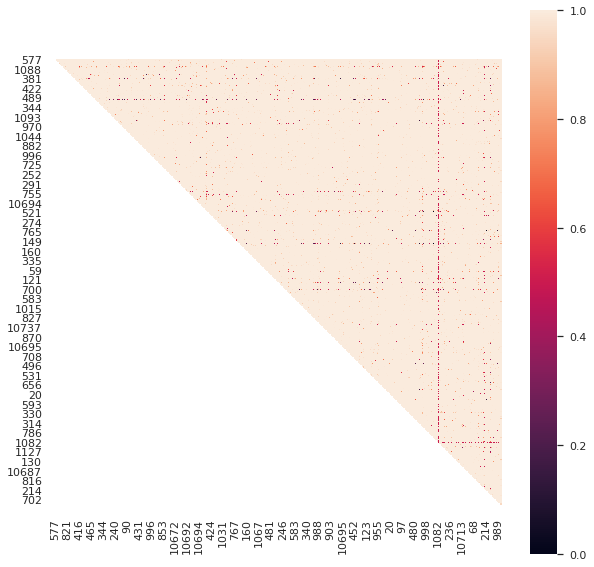

In [14]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall)
print("test set")
uppertriheatmap(test_allbyall)

are there any missing values after copying over diagonal?
False


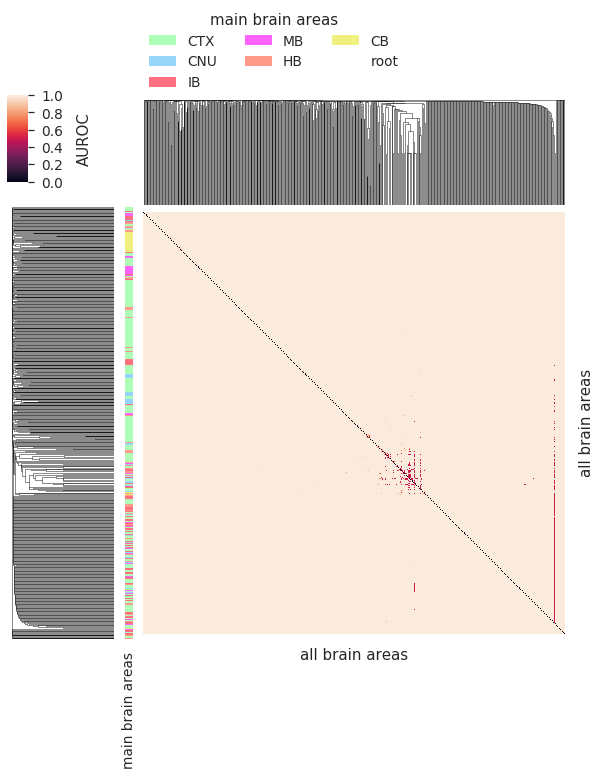

are there any missing values after copying over diagonal?
False


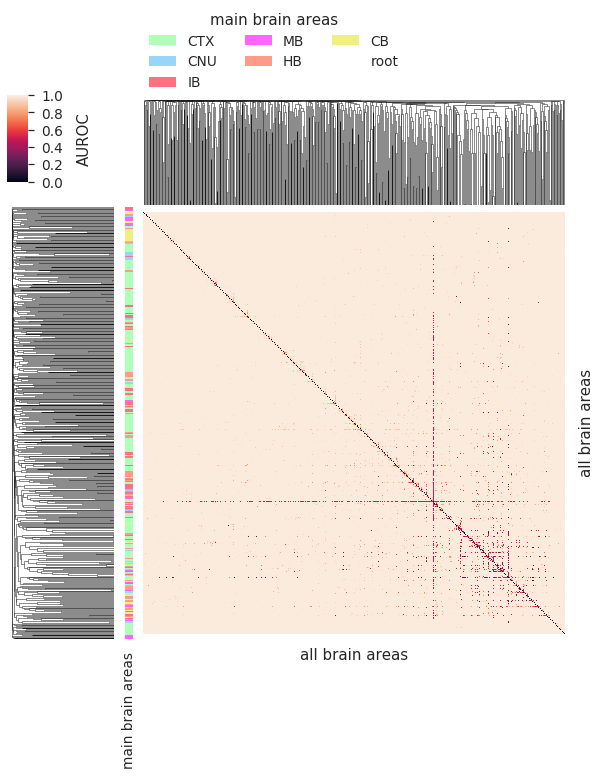

In [15]:
#clustermaps
clustermap(train_allbyall, ontology, False)#"042120_1.png")
clustermap(test_allbyall, ontology, False)#"042120_2.png")

number of 0's in upper triangular: 0


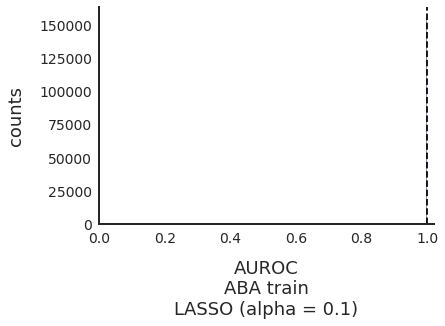

mean AUROC for upper triangular: 0.998514
number of 0's in upper triangular: 4


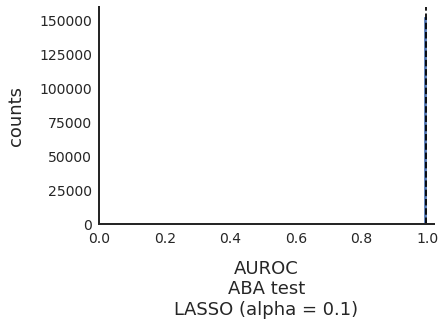

mean AUROC for upper triangular: 0.995243


In [16]:
#upper triangular histogram
uppertrihist(train_allbyall, "AUROC\nABA train\nLASSO (alpha = 0.1)", 0, 0, 0, False)#"042120_3.pdf")
uppertrihist(test_allbyall, "AUROC\nABA test\nLASSO (alpha = 0.1)", 0, 0, 0, False)#"042120_4.pdf")
#uppertrihist(test_allbyall, "AUROC\nST test\nLASSO (alpha = 0.1)", 1, 0, 100000, "042120_5.pdf")

### fold 2

__read in all by all files__

In [14]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1_f2_train0420.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p1_f2_test0420.csv"

In [15]:
train_allbyall_f2 = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall_f2 = train_allbyall_f2.set_index(train_allbyall_f2.columns)

test_allbyall_f2 = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall_f2 = test_allbyall_f2.set_index(test_allbyall_f2.columns)

__plots__

train set


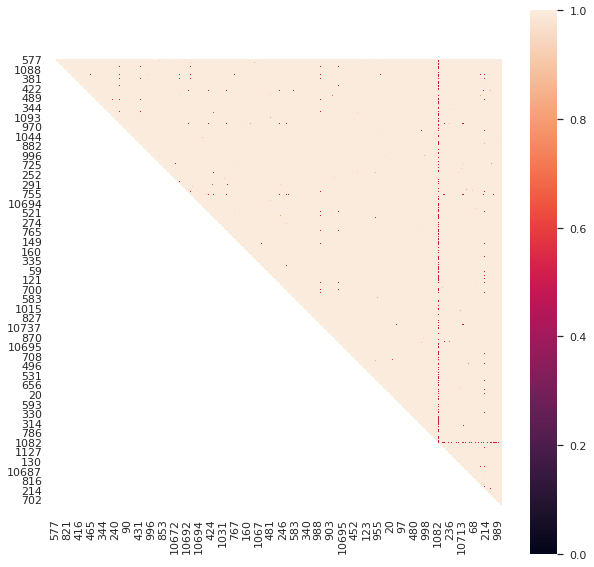

test set


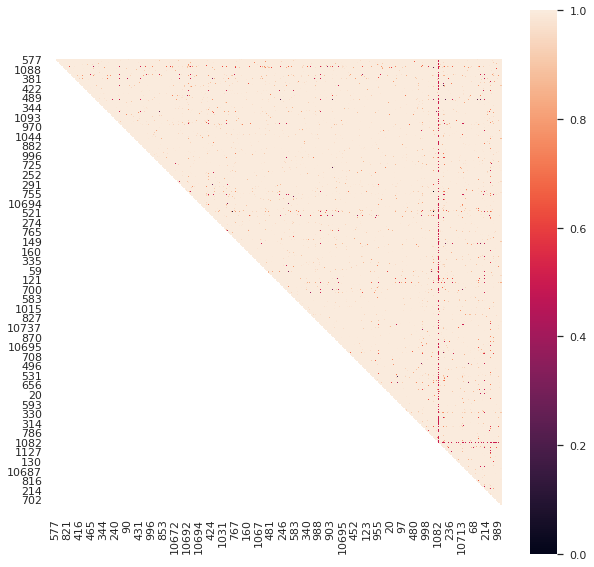

In [34]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall_f2)
print("test set")
uppertriheatmap(test_allbyall_f2)

are there any missing values after copying over diagonal?
False


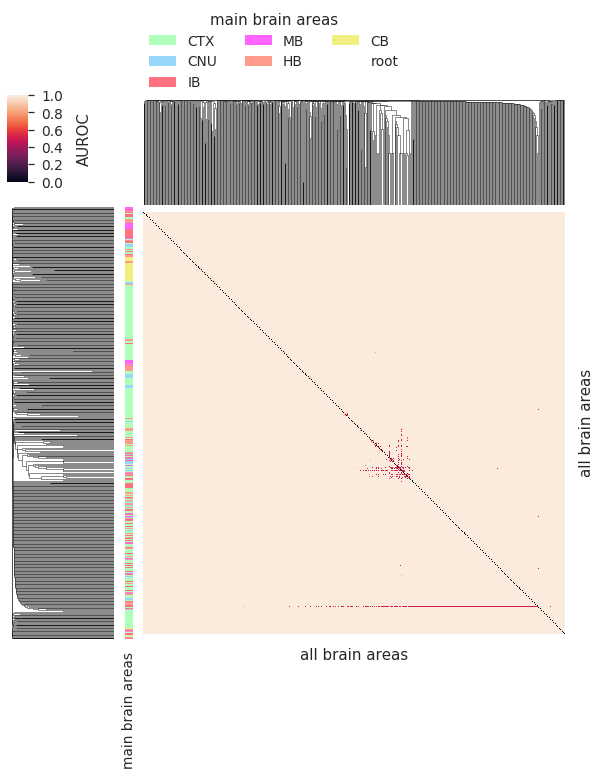

are there any missing values after copying over diagonal?
False


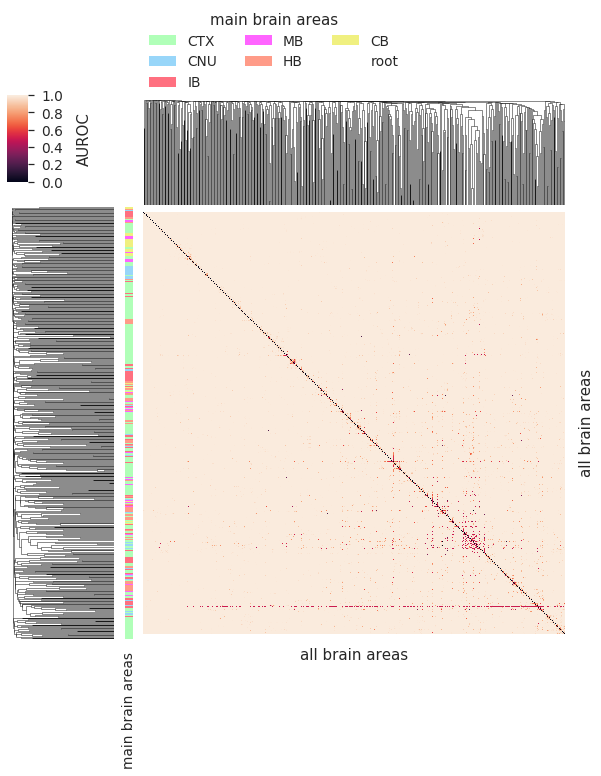

In [35]:
#clustermaps
clustermap(train_allbyall_f2, ontology, "042120_5.png")
clustermap(test_allbyall_f2, ontology, "042120_6.png")

number of 0's in upper triangular: 0


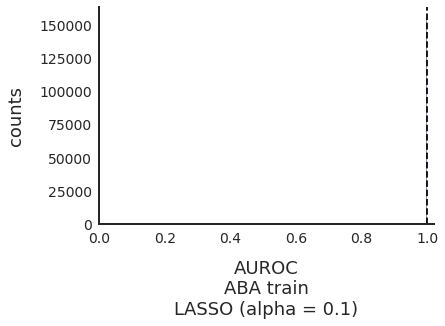

mean AUROC for upper triangular: 0.998634
number of 0's in upper triangular: 2


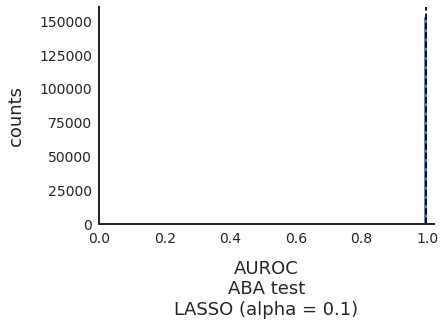

mean AUROC for upper triangular: 0.996470


In [36]:
#upper triangular histogram
uppertrihist(train_allbyall_f2, "AUROC\nABA train\nLASSO (alpha = 0.1)", 0, 0, 0, "041420_7.pdf")
uppertrihist(test_allbyall_f2, "AUROC\nABA test\nLASSO (alpha = 0.1)", 0, 0, 0, "041420_8.pdf")

### cross validation

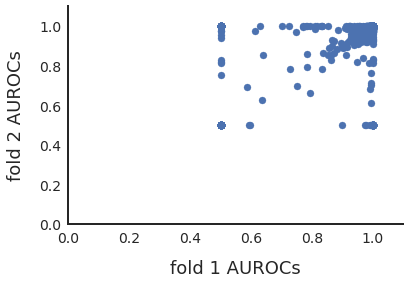

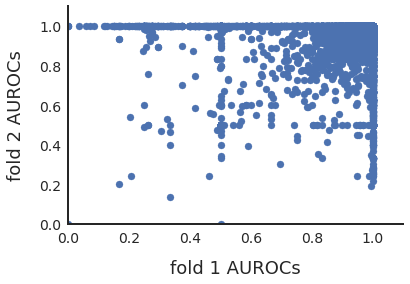

In [37]:
scatfolds(train_allbyall, train_allbyall_f2, "042120_9.pdf")
scatfolds(test_allbyall, test_allbyall_f2, "042120_10.pdf")

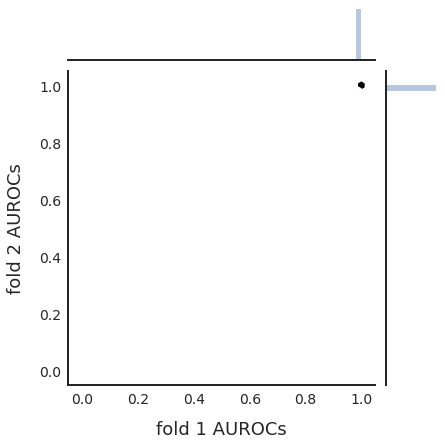

In [38]:
scatfolds2(test_allbyall, test_allbyall_f2, "042120_11.pdf")

__average of the two test folds__

In [16]:
test_allbyall_avg = (test_allbyall + test_allbyall_f2)/2

are there any missing values after copying over diagonal?
False


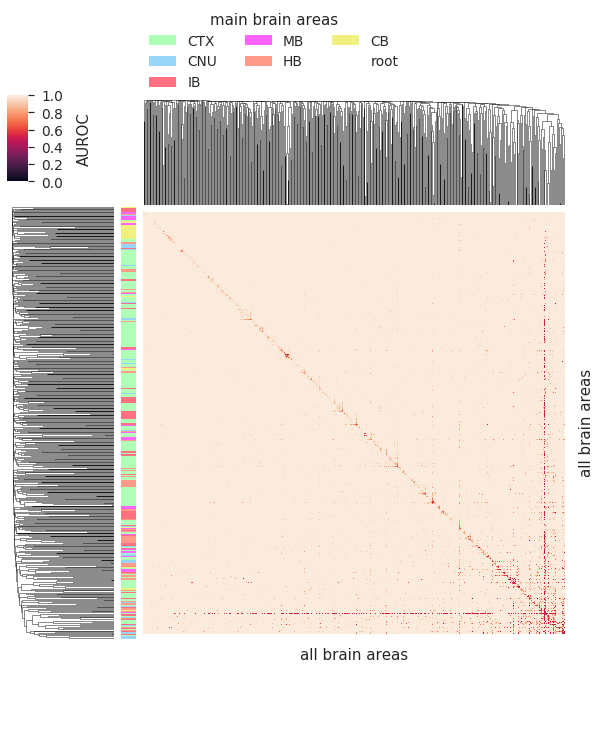

In [22]:
#clustermaps
clustermap(test_allbyall_avg, ontology, "072920_2.png")

number of 0's in upper triangular: 1


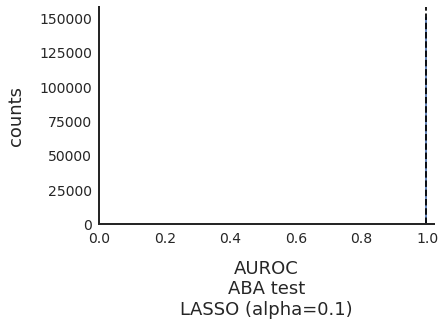

mean AUROC for upper triangular: 0.995844


In [41]:
#upper triangular histogram
uppertrihist(test_allbyall_avg, "AUROC\nABA test\nLASSO (alpha=0.1)", 0, 0, 0, "042120_13.pdf")

number of 0's in upper triangular: 0


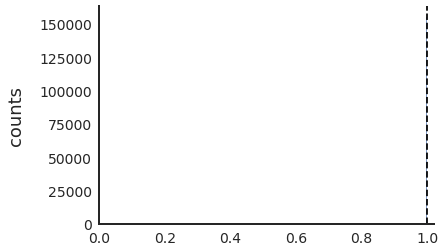

mean AUROC for upper triangular: 0.998574


In [21]:
#train fold for summary plot
train_allbyall_avg = (train_allbyall + train_allbyall_f2)/2
uppertrihist(train_allbyall_avg,"",0,0,0,False)

In [17]:
#caudoputamen mean AUROC, without 0's
test_allbyall_avg.loc[test_allbyall_avg['672']!=0,'672'].mean()

0.7841747971898506

# ABA ISH LASSO all by all alpha = 0.05

### fold 1

__read in all by all files__

In [24]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p05_train0422.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p05_test0422.csv"

In [25]:
train_allbyall = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall = train_allbyall.set_index(train_allbyall.columns)

test_allbyall = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall = test_allbyall.set_index(test_allbyall.columns)

__plots__

train set


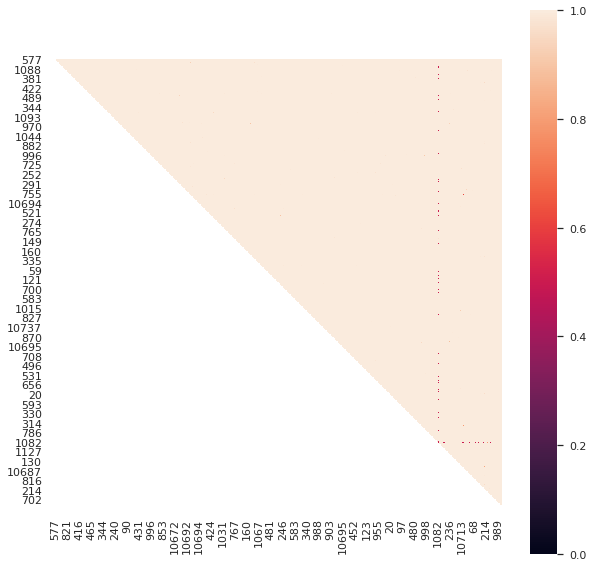

test set


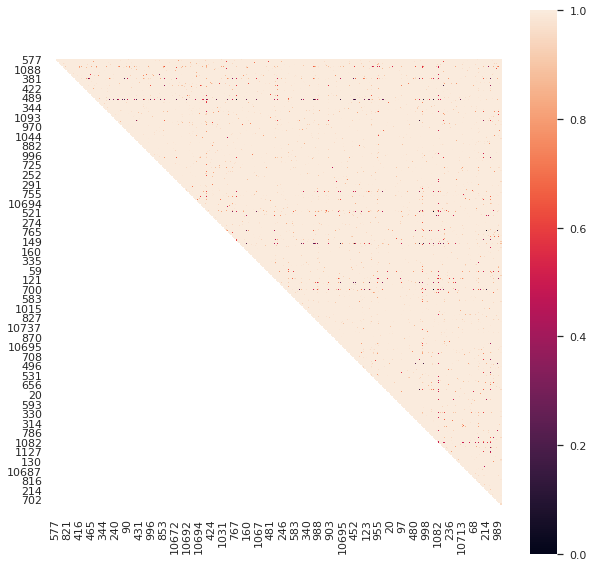

In [16]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall)
print("test set")
uppertriheatmap(test_allbyall)

are there any missing values after copying over diagonal?
False


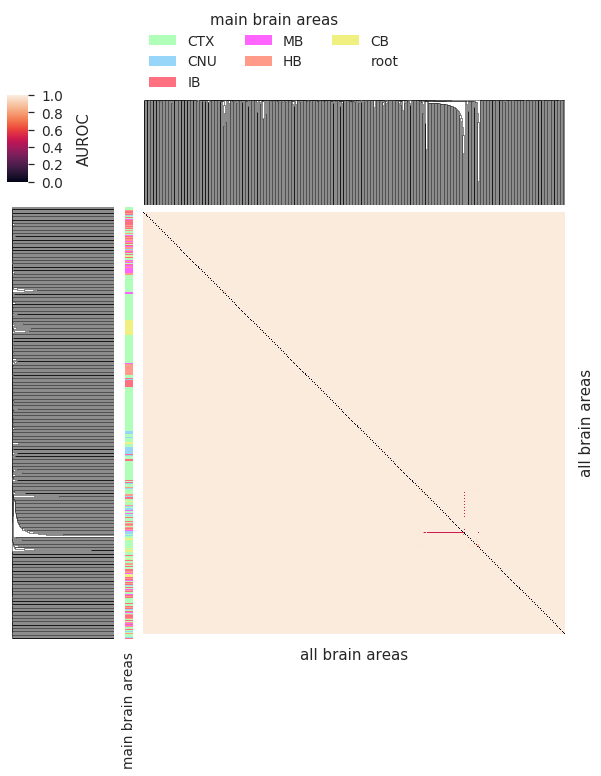

are there any missing values after copying over diagonal?
False


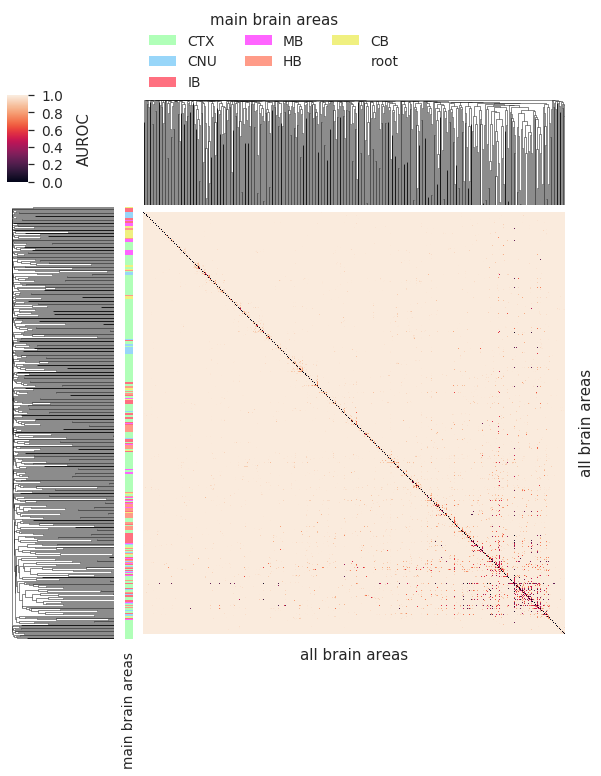

In [18]:
#clustermaps
clustermap(train_allbyall, ontology, "051020_1.png")
clustermap(test_allbyall, ontology, "051020_2.png")

number of 0's in upper triangular: 0


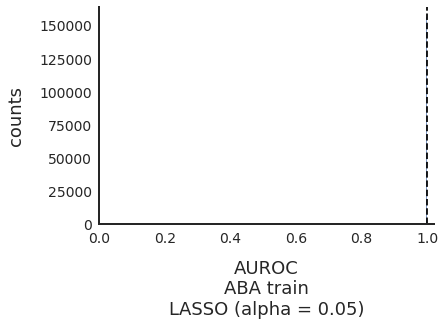

mean AUROC for upper triangular: 0.999801
number of 0's in upper triangular: 7


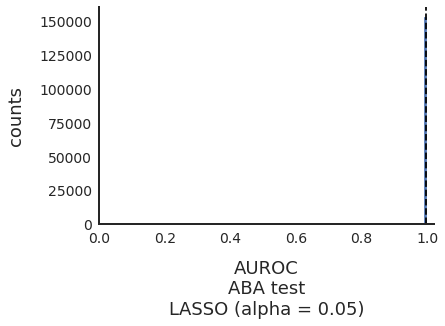

mean AUROC for upper triangular: 0.997020


In [24]:
#upper triangular histogram
uppertrihist(train_allbyall, "AUROC\nABA train\nLASSO (alpha = 0.05)", 0, 0, 0, "051020_3.pdf")
uppertrihist(test_allbyall, "AUROC\nABA test\nLASSO (alpha = 0.05)", 0, 0, 0, "051020_4.pdf")
#uppertrihist(test_allbyall, "AUROC\nST test\nLASSO (alpha = 0.1)", 1, 0, 100000, "042120_5.pdf")

### fold 2

__read in all by all files__

In [26]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p05_f2_train0422.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0p05_f2_test0422.csv"

In [27]:
train_allbyall_f2 = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall_f2 = train_allbyall_f2.set_index(train_allbyall_f2.columns)

test_allbyall_f2 = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall_f2 = test_allbyall_f2.set_index(test_allbyall_f2.columns)

__plots__

train set


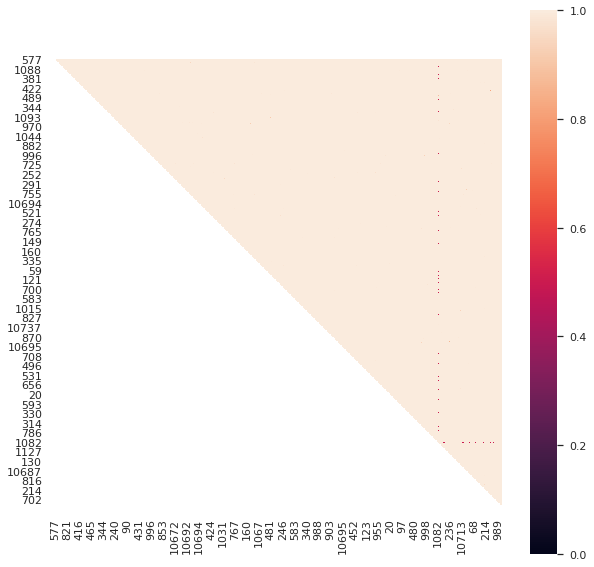

test set


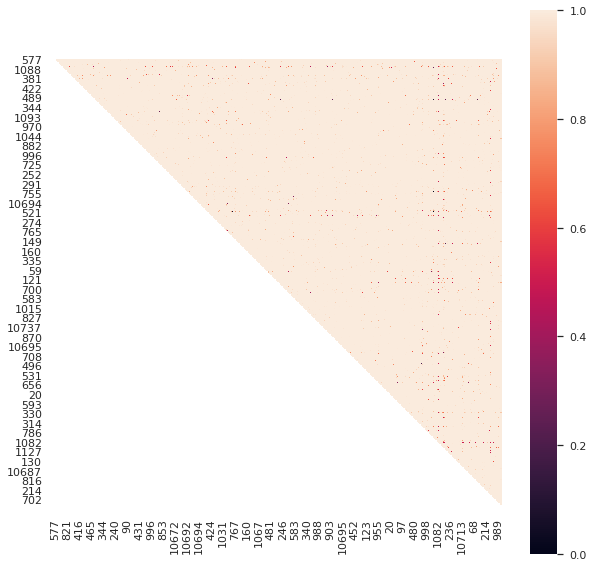

In [22]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall_f2)
print("test set")
uppertriheatmap(test_allbyall_f2)

are there any missing values after copying over diagonal?
False


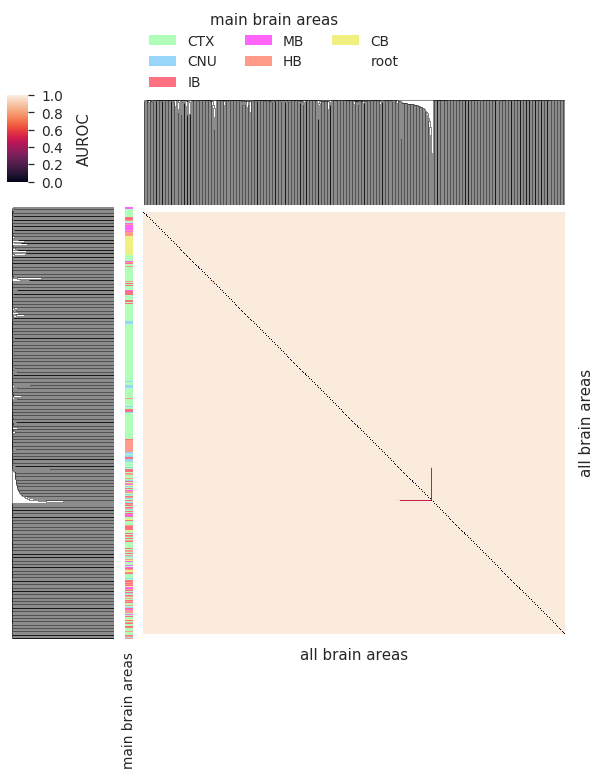

are there any missing values after copying over diagonal?
False


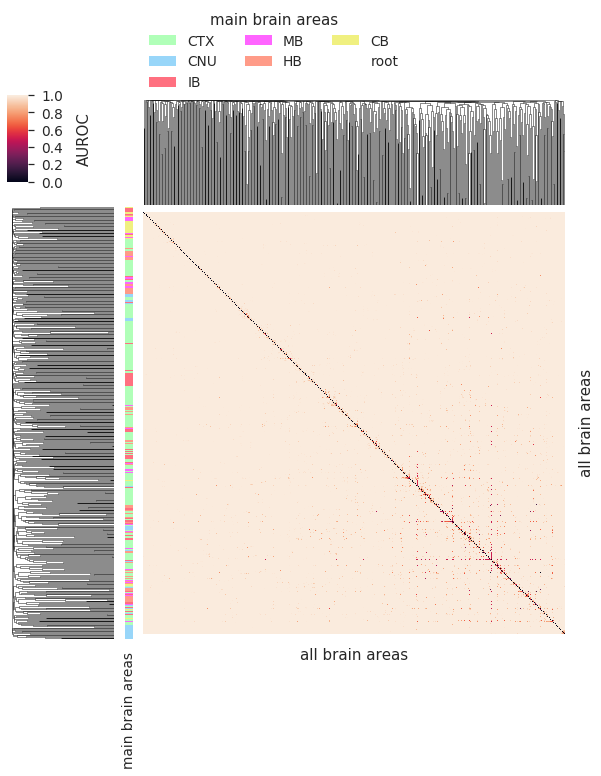

In [23]:
#clustermaps
clustermap(train_allbyall_f2, ontology, "051020_5.png")
clustermap(test_allbyall_f2, ontology, "051020_6.png")

number of 0's in upper triangular: 0


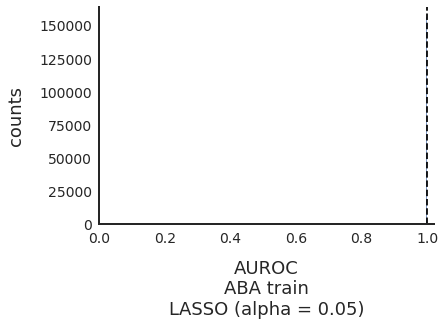

mean AUROC for upper triangular: 0.999845
number of 0's in upper triangular: 2


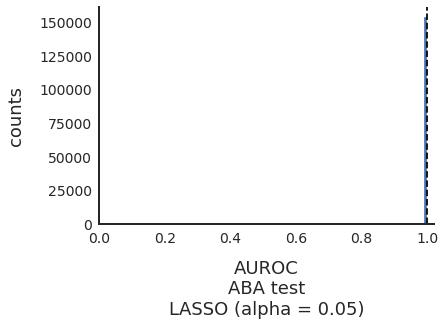

mean AUROC for upper triangular: 0.998066


In [25]:
#upper triangular histogram
uppertrihist(train_allbyall_f2, "AUROC\nABA train\nLASSO (alpha = 0.05)", 0, 0, 0, "051020_7.pdf")
uppertrihist(test_allbyall_f2, "AUROC\nABA test\nLASSO (alpha = 0.05)", 0, 0, 0, "051020_8.pdf")

### cross validation

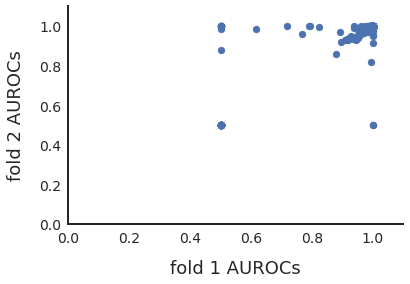

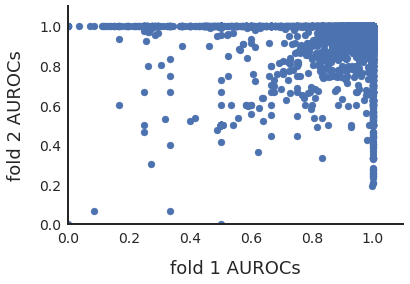

In [26]:
scatfolds(train_allbyall, train_allbyall_f2, "051020_9.pdf")
scatfolds(test_allbyall, test_allbyall_f2, "051020_10.pdf")

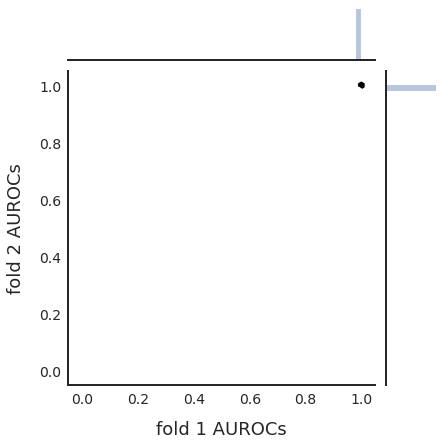

In [27]:
scatfolds2(test_allbyall, test_allbyall_f2, "051020_11.pdf")

__average of the two test folds__

In [28]:
test_allbyall_avg = (test_allbyall + test_allbyall_f2)/2

are there any missing values after copying over diagonal?
False


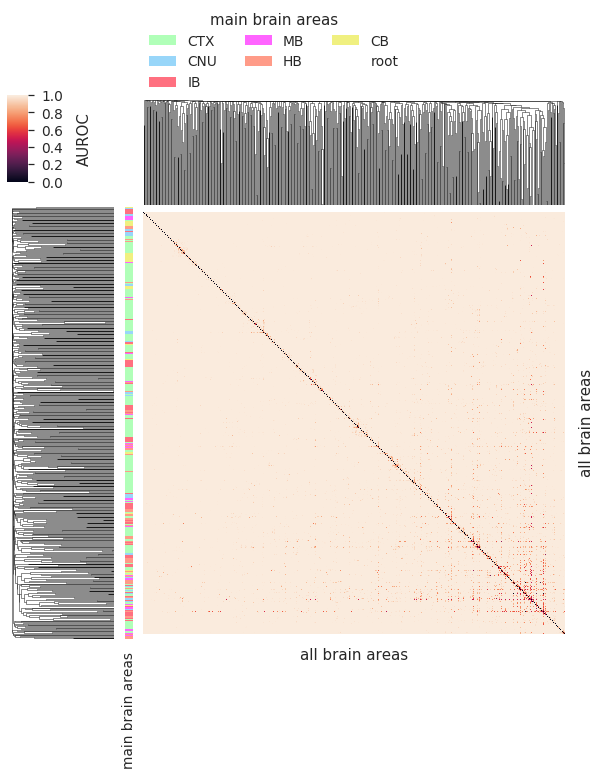

In [29]:
#clustermaps
clustermap(test_allbyall_avg, ontology, "051020_12.png")

number of 0's in upper triangular: 1


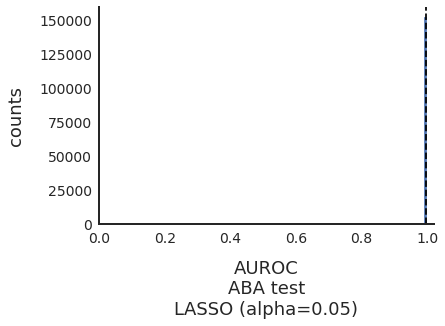

mean AUROC for upper triangular: 0.997521


In [29]:
#upper triangular histogram
uppertrihist(test_allbyall_avg, "AUROC\nABA test\nLASSO (alpha=0.05)", 0, 0, 0, False)#"051020_13.pdf")

number of 0's in upper triangular: 0


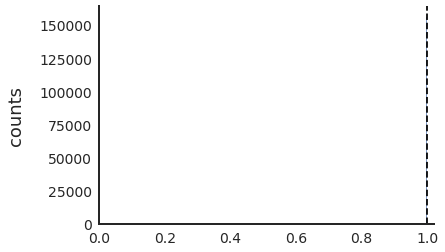

mean AUROC for upper triangular: 0.999823


In [30]:
#train fold for summary plot
train_allbyall_avg = (train_allbyall + train_allbyall_f2)/2
uppertrihist(train_allbyall_avg,"",0,0,0,False)

# ABA ISH linear regression all by all (alpha = 0)

### fold 1

__read in all by all files__

In [31]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0_train0428.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0_test0428.csv"

In [32]:
train_allbyall = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall = train_allbyall.set_index(train_allbyall.columns)

test_allbyall = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall = test_allbyall.set_index(test_allbyall.columns)

__plots__

train set


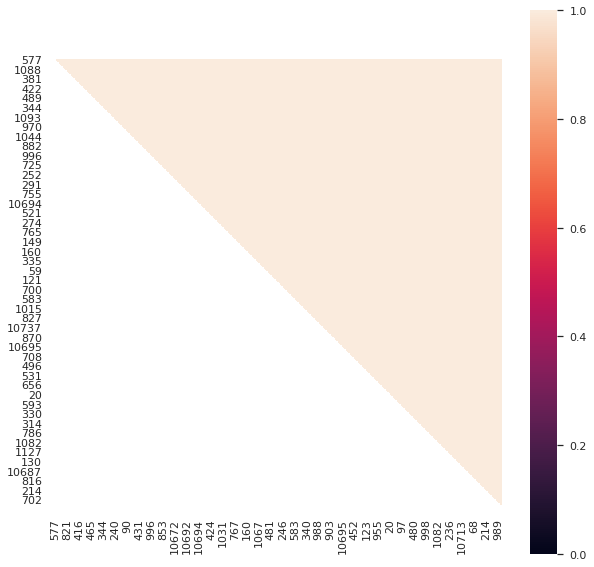

test set


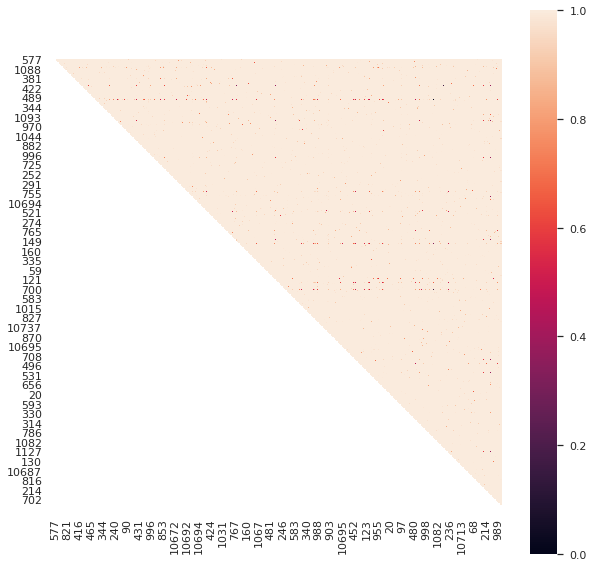

In [33]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall)
print("test set")
uppertriheatmap(test_allbyall)

are there any missing values after copying over diagonal?
False


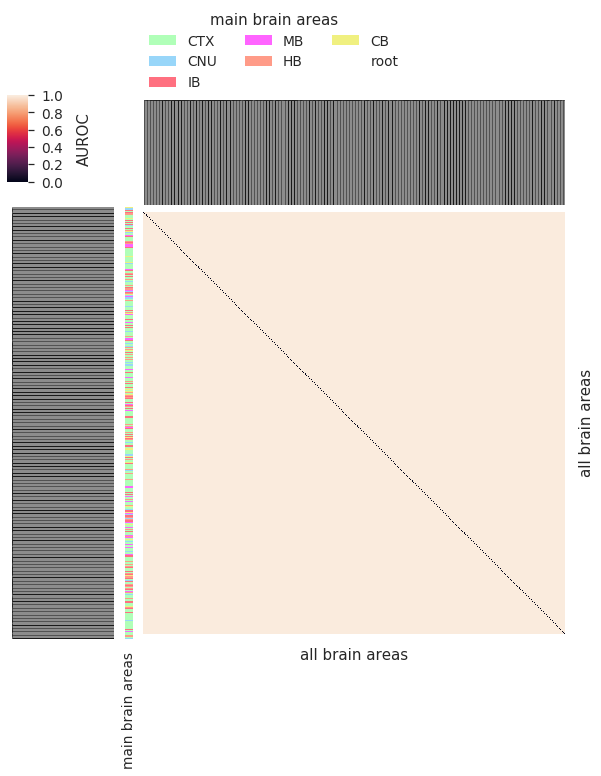

are there any missing values after copying over diagonal?
False


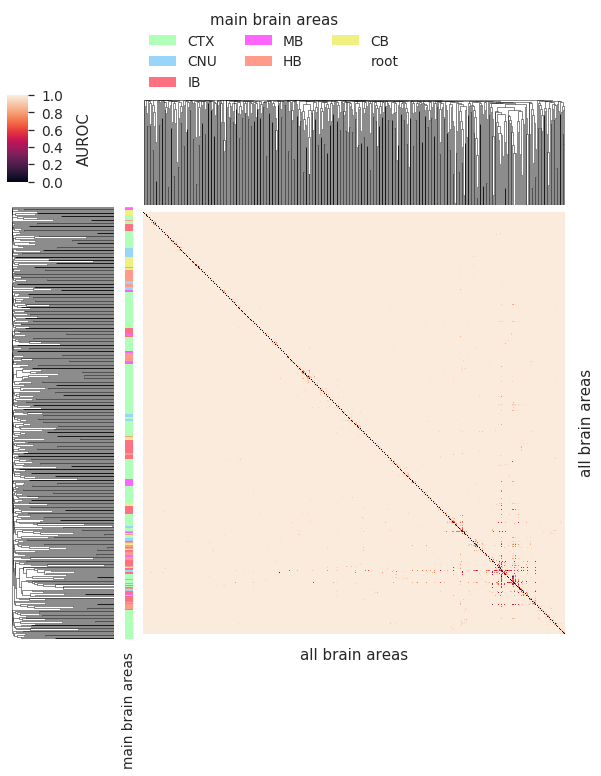

In [35]:
#clustermaps
clustermap(train_allbyall, ontology, "051020_14.png")
clustermap(test_allbyall, ontology, "051020_15.png")

number of 0's in upper triangular: 0


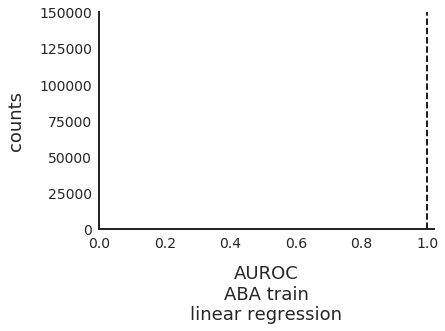

mean AUROC for upper triangular: 1.000000
number of 0's in upper triangular: 1


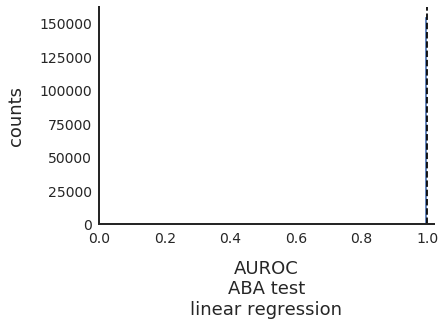

mean AUROC for upper triangular: 0.998757


In [36]:
#upper triangular histogram
uppertrihist(train_allbyall, "AUROC\nABA train\nlinear regression", 0, 0, 0, "051020_16.pdf")
uppertrihist(test_allbyall, "AUROC\nABA test\nlinear regression", 0, 0, 0, "051020_17.pdf")
#uppertrihist(test_allbyall, "AUROC\nST test\nLASSO (alpha = 0.1)", 1, 0, 100000, "042120_5.pdf")

### fold 2

__read in all by all files__

In [33]:
TRAIN_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0_f2_train0422.csv"
TEST_ALLBYALL_PATH = "/home/slu/spatial/data/allbyall_lasso/allbyallABA0_f2_test0422.csv"

In [34]:
train_allbyall_f2 = pd.read_csv(TRAIN_ALLBYALL_PATH, sep=',')
train_allbyall_f2 = train_allbyall_f2.set_index(train_allbyall_f2.columns)

test_allbyall_f2 = pd.read_csv(TEST_ALLBYALL_PATH, sep=',')
test_allbyall_f2 = test_allbyall_f2.set_index(test_allbyall_f2.columns)

__plots__

train set


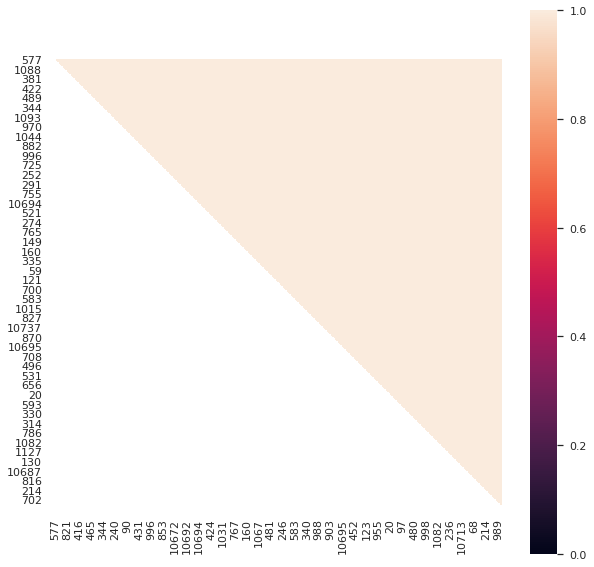

test set


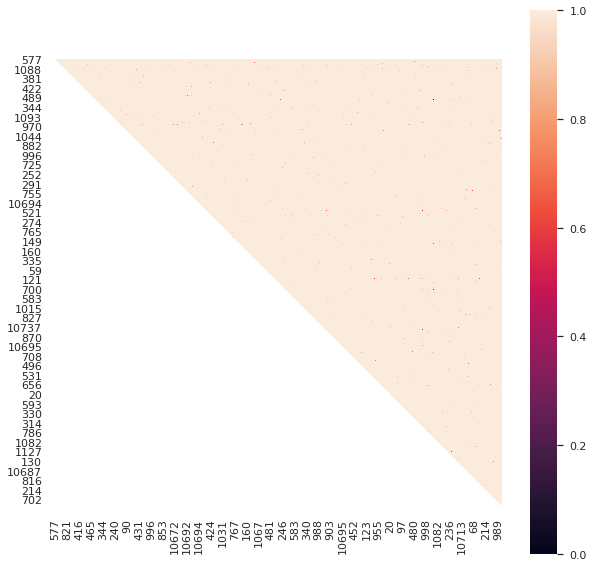

In [41]:
#first look at allbyall outfiles
print("train set")
uppertriheatmap(train_allbyall_f2)
print("test set")
uppertriheatmap(test_allbyall_f2)

are there any missing values after copying over diagonal?
False


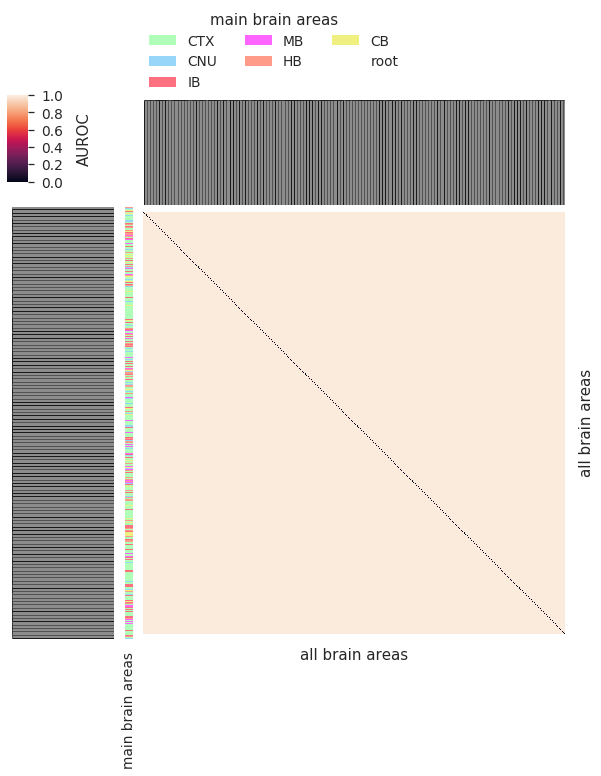

are there any missing values after copying over diagonal?
False


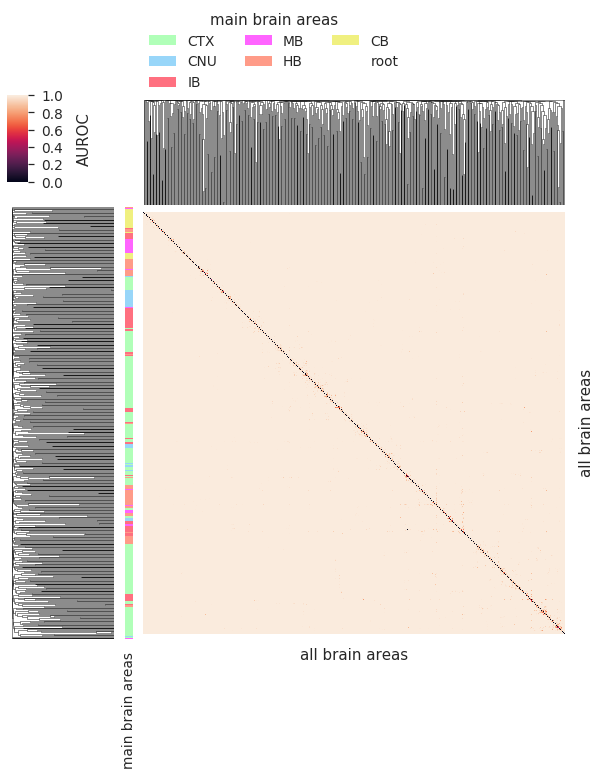

In [42]:
#clustermaps
clustermap(train_allbyall_f2, ontology, "051020_18.png")
clustermap(test_allbyall_f2, ontology, "051020_19.png")

number of 0's in upper triangular: 0


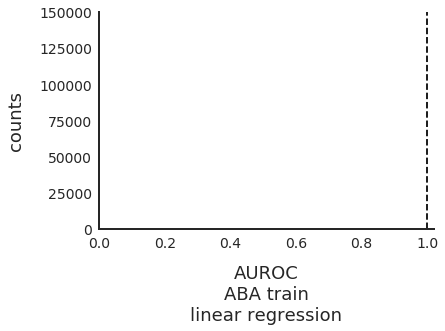

mean AUROC for upper triangular: 1.000000
number of 0's in upper triangular: 1


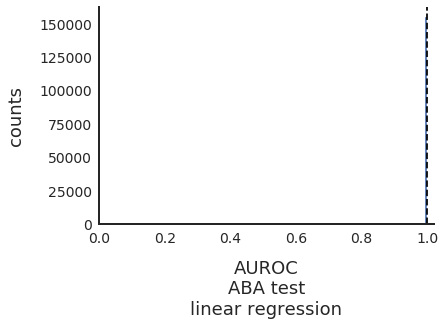

mean AUROC for upper triangular: 0.999404


In [43]:
#upper triangular histogram
uppertrihist(train_allbyall_f2, "AUROC\nABA train\nlinear regression", 0, 0, 0, "051020_20.pdf")
uppertrihist(test_allbyall_f2, "AUROC\nABA test\nlinear regression", 0, 0, 0, "051020_21.pdf")

### cross validation

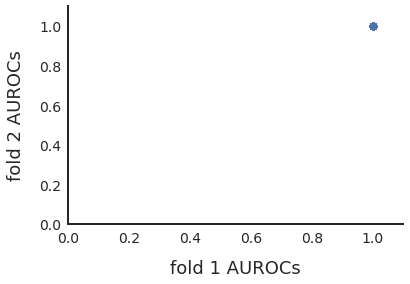

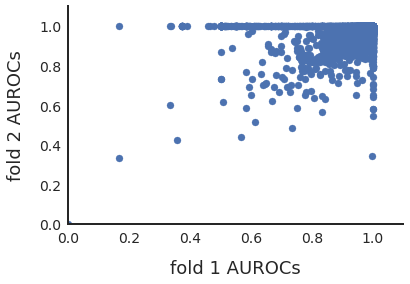

In [44]:
scatfolds(train_allbyall, train_allbyall_f2, "051020_22.pdf")
scatfolds(test_allbyall, test_allbyall_f2, "051020_23.pdf")

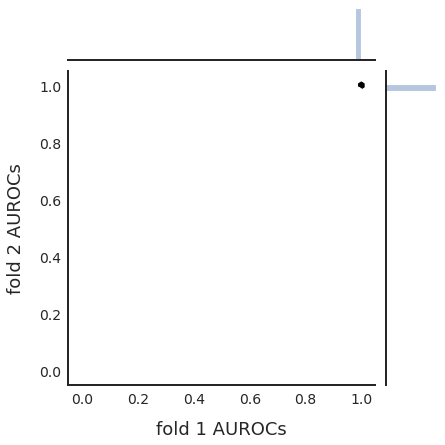

In [45]:
scatfolds2(test_allbyall, test_allbyall_f2, "051020_24.pdf")

__average of the two test folds__

In [35]:
test_allbyall_avg = (test_allbyall + test_allbyall_f2)/2

are there any missing values after copying over diagonal?
False


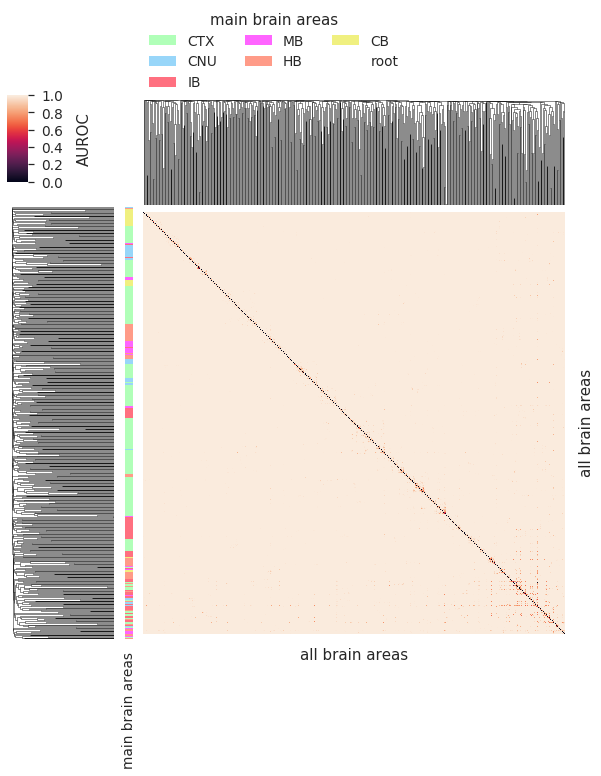

In [49]:
#clustermaps
clustermap(test_allbyall_avg, ontology, "051020_25.png")

number of 0's in upper triangular: 1


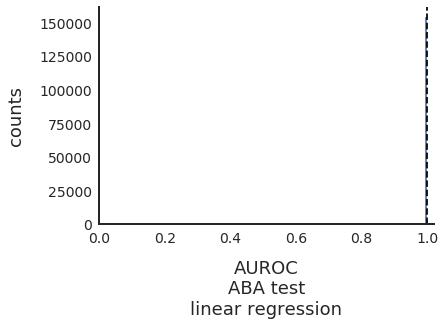

mean AUROC for upper triangular: 0.999081


In [36]:
#upper triangular histogram
uppertrihist(test_allbyall_avg, "AUROC\nABA test\nlinear regression", 0, 0, 0, False)#"051020_26.pdf")

number of 0's in upper triangular: 0


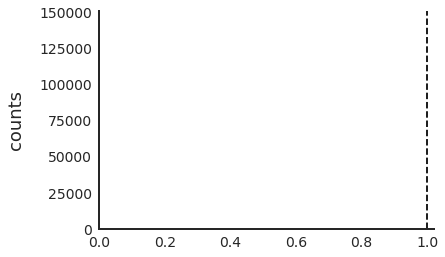

mean AUROC for upper triangular: 1.000000


In [37]:
#train fold for summary plot
train_allbyall_avg = (train_allbyall + train_allbyall_f2)/2
uppertrihist(train_allbyall_avg,"",0,0,0,False)